In [206]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, circuit, extensions
import matplotlib.pyplot as plt
import math
import numpy as np
from functools import reduce
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from datetime import datetime
from qiskit.aqua.components.optimizers import COBYLA, ADAM, AQGD, NFT

In [125]:
def normalize(l):
    normalization_factor = math.sqrt(sum([i ** 2 for i in l]))
    return [i / normalization_factor for i in l]

def init_gate(init_states, label=None, size=None):
    if not size:
        size = math.ceil(math.log2(len(init_states)))
    state_vector = normalize(init_states) + [0] * ((2 ** size) - len(init_states))
    #I know this is way ugly, but it's the easiest way to actualy turn initialize() into a gate
    return extensions.Initialize(state_vector).gates_to_uncompute().inverse().to_gate(label=label if label else None)

In [126]:
def x_indices(i, bits):
    indices = []
    for j in range(bits):
        bit = (i >> j) & 1
        if not bit:
            indices.append(j)
    return indices

In [194]:
def construct_oracle(data, labels):
    # gate = init_gate([0,2,10], "psi_0")
    data_bits = math.ceil(math.log2(data.shape[1]))
    counting_bits = math.ceil(math.log2(data.shape[0]))
#     print(len(data), data.shape[0])
    q = QuantumRegister(data_bits + counting_bits + 1)
    qc = QuantumCircuit(q)

#     data = [[x,x*2,x**2] for x in range(1, 16)]
    qc.h(q[data_bits + 1:])
    for i in range(len(data)):
        x_i = [data_bits + 1 + x_i for x_i in x_indices(i,counting_bits)]
        if len(x_i) > 0:
            qc.x(x_i)
        gate = init_gate(data[i], f"psi_{i}", data_bits).control(counting_bits)
        qc.append(gate, q[data_bits + 1:] + q[:data_bits])
        if labels[i] == 1:
            x_gate = circuit.library.XGate().control(counting_bits)
            qc.append(x_gate, q[data_bits + 1:] + [q[data_bits]])

        if len(x_i) > 0:
            qc.x(x_i)
    return qc, data_bits, counting_bits

In [128]:
def destructive_swap(n):
    q = QuantumRegister(n * 2)
    circuit = QuantumCircuit(q)
    
    for i in range(n):
        circuit.cx(i, n+i)
        circuit.h(i)
#     print(circuit)
    return circuit.to_gate(label="destructive_swap")


In [129]:
def interpret_des_swap(counts):
    successes = 0
    for k in counts:
        #success if and of measurement has even parity, that's what the paper said
        success = reduce(lambda b, p: (p == ('1', '1')) ^ b , zip(list(k[:len(k)//2]), list(k[len(k)//2:])), True)
#         print(k, success)
#         success = k.count('1') % 2 == 0
        if success:
            successes += counts[k]
    if sum(counts.values()) == 0:
        return 0
    return  2 * (successes / sum(counts.values())) - 1

In [130]:
def construct_classifier(data, labels):
    input_size = math.ceil(math.log2(data.shape[1]))
    oracle, data_bits, counting_bits = construct_oracle(data, labels)
    print(oracle)
    oracle = oracle.to_gate(label="oracle")
    q = QuantumRegister(input_size + data_bits + counting_bits + 1)
    c = ClassicalRegister(input_size * 2 + 1)
    qc = QuantumCircuit(q, c)
    
    qc.append(oracle, q[input_size:])
#     print(input_size)
    qc.append(destructive_swap(input_size), q[:input_size] + q[input_size:input_size+input_size])
    for i in range(input_size * 2 + 1):
        qc.measure(i,i)
    return qc


In [131]:
df = pd.read_csv("bezdekIris.data", header=None)

In [132]:
df[4] = [0 if p == "Iris-setosa" else 1 if p == "Iris-virginica" else 2 for p in df[4]]
df = df[df[4] != 2]

In [165]:
train, test = train_test_split(df, test_size=0.36)
data = train[[0,1]].to_numpy()
labels = train[4].to_numpy()
label0 = -1
label1 = -1

for i in range(len(labels)):
    if labels[i] == 0:
        label0 = i
    if labels[i] == 1:
        label1 = i
        
    if label0 != -1 and label1 != -1:
        break

data = data[[label0, label1]]
labels = labels[[label0, label1]]

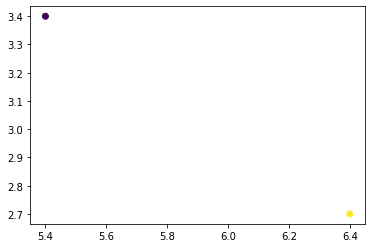

In [166]:
plt.scatter(x=data[:, 0], y=data[:, 1], c=labels)
plt.show()

/home/mauk/.local/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


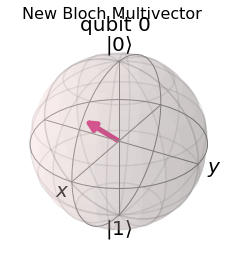

In [167]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

inp_gate = init_gate([6.5, 3], label="input", size=1)

qc.append(inp_gate, q[0:1])

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state, title="New Bloch Multivector", reverse_bits=False)

/home/mauk/.local/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


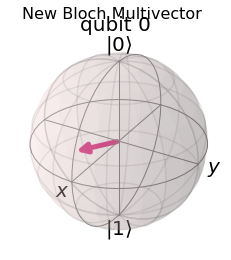

In [168]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

inp_gate = init_gate([5, 3.5], label="input", size=1)

qc.append(inp_gate, q[0:1])

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state, title="New Bloch Multivector", reverse_bits=False)

In [169]:
# data = np.ones((20,4))
# data = np.array([np.array([1,2,0,4]) for i in range(20)])


qc_classifier = construct_classifier(data, labels)


2 2
                   ┌───────┐     ┌───────┐     
q9581_0: ──────────┤ psi_0 ├─────┤ psi_1 ├─────
                   └───┬───┘     └───┬───┘┌───┐
q9581_1: ──────────────┼─────────────┼────┤ X ├
         ┌───┐┌───┐    │    ┌───┐    │    └─┬─┘
q9581_2: ┤ H ├┤ X ├────■────┤ X ├────■──────■──
         └───┘└───┘         └───┘              


In [170]:
def classify(inp):
    num_qubits = qc_classifier.num_qubits

    data_size = math.ceil(math.log2(data.shape[1]))

    num_cbits = data_size * 2 + 1


    q = QuantumRegister(num_qubits)
    c = ClassicalRegister(num_cbits)
    qc = QuantumCircuit(q, c)

    # inp_gate = init_gate([1,2,0,4])
    inp_gate = init_gate(inp, label="input", size=data_size)


    qc.append(inp_gate, q[0:1])
    qc = qc.compose(qc_classifier)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=qc, shots=500)
    result = job.result()

    counts = result.get_counts()
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))

In [171]:
labels = [0,1]
correct = 0
count = 0
for index, row in test.iterrows():
    label = row[4]
    results = classify(row[[0,1]].tolist())
    cor = False
    if results[0] > results[1] and label == labels[0]:
        correct += 1
        cor = True
    elif results[0] < results[1] and label == labels[1]:
        correct += 1
        cor = True
    count += 1
    print(f"features:({row[0]}, {row[1]}), label:{label}, result:{labels[0]}:{results[0]}, {labels[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

print(correct / len(test))


features:(5.9, 3.0), label:1.0, result:0:0.9838709677419355, 1:1.0, correct, accuracy:1.0
features:(7.9, 3.8), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.5
features:(5.7, 4.4), label:0.0, result:0:0.9924812030075187, 1:0.9572649572649572, correct, accuracy:0.6666666666666666
features:(6.3, 3.4), label:1.0, result:0:0.9920318725099602, 1:0.9919678714859437, incorrect, accuracy:0.5
features:(4.6, 3.4), label:0.0, result:0:0.9920948616600791, 1:0.9271255060728745, correct, accuracy:0.6
features:(6.3, 2.9), label:1.0, result:0:0.9717314487632509, 1:1.0, correct, accuracy:0.6666666666666666
features:(6.3, 2.8), label:1.0, result:0:0.9741379310344827, 1:1.0, correct, accuracy:0.7142857142857143
features:(5.4, 3.4), label:0.0, result:0:1.0, 1:0.9423868312757202, correct, accuracy:0.75
features:(6.5, 3.0), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.6666666666666666
features:(5.0, 3.2), label:0.0, result:0:1.0, 1:0.9843137254901961, correct, accuracy:0.7
features:(4.9, 3.1

In [172]:
num_qubits = qc_classifier.num_qubits

data_size = math.ceil(math.log2(data.shape[1]))

num_cbits = data_size * 2 + 1


q = QuantumRegister(num_qubits)
c = ClassicalRegister(num_cbits)
qc = QuantumCircuit(q, c)

# inp_gate = init_gate([1,2,0,4])
inp_gate = init_gate([1,2], label="input", size=data_size)

qc.append(inp_gate, q[0:1])
qc = qc.compose(qc_classifier)
print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=2000)
result = job.result()

# print(result.get_counts())
counts = result.get_counts()

counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

print(counts)
print(interpret_des_swap(counts_0))
print(interpret_des_swap(counts_1))

           ┌───────┐ ┌───────────────────┐┌─┐   
q10776_0: ─┤ input ├─┤0                  ├┤M├───
          ┌┴───────┴┐│  destructive_swap │└╥┘┌─┐
q10776_1: ┤0        ├┤1                  ├─╫─┤M├
          │         │└────────┬─┬────────┘ ║ └╥┘
q10776_2: ┤1 oracle ├─────────┤M├──────────╫──╫─
          │         │         └╥┘          ║  ║ 
q10776_3: ┤2        ├──────────╫───────────╫──╫─
          └─────────┘          ║           ║  ║ 
  c361: 3/═════════════════════╩═══════════╩══╩═
                               2           0  1 
{'101': 1, '001': 8, '010': 513, '100': 303, '110': 483, '011': 137, '000': 359, '111': 196}
0.7305801376597836
0.6012207527975586


In [173]:
# n_features gets boiled down to amount of qubits necessary for it to work TODO: Change n_labels to do the same
def build_variational_circuit(depth, n_features, n_labels, params=None, measurement=False):
    # TODO: Add y and z rotations
    n_qubits = math.ceil(math.log2(n_features)) + n_labels
    
    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum
    
    n_qubits_per_layer = n_qubits + seriessum(n_qubits)
    n_rot_qubits_per_layer = n_qubits
    n_entangle_qubits_per_layer = seriessum(n_qubits)
    
#     print(params)
    
    if not params:
        params = np.random.rand(depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi
    
#     print(params)
    
#     print(len(params))
    
    q = QuantumRegister(n_qubits)
    if measurement:
        c = ClassicalRegister(n_qubits)
        qc = QuantumCircuit(q, c)
    else:
        qc = QuantumCircuit(q)
        
    
    # Dynamically add rx rotation and rxx entanglement gates
    for i in range(depth):
        for j in range(n_qubits):
#             print(i * depth, j)
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            qc.rx(params[i * n_qubits_per_layer + j], j)
        next_param = 0
        for j in range(n_qubits):
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            for k in range(n_qubits):
                if j == k or j < k:
                    continue
#                 print(i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param)
#                 print(i * n_rot_qubits_per_layer + j + next_param + n_rot_qubits_per_layer)
                qc.rxx(params[i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param], j, k)
                next_param += 1
        
        if measurement:
            qc.barrier()
    
    if measurement:
        for i in range(n_qubits):
            qc.measure(i, i)
            
    return qc
      
build_variational_circuit(8, 2, 1).draw()

┌────────────┐┌──────────────┐┌────────────┐┌───────────────┐»
q10809_0: ┤ Rx(2.5108) ├┤1             ├┤ Rx(1.6075) ├┤1              ├»
          ├────────────┤│  Rxx(1.4192) │├────────────┤│  Rxx(0.83553) │»
q10809_1: ┤ Rx(2.2563) ├┤0             ├┤ Rx(1.5656) ├┤0              ├»
          └────────────┘└──────────────┘└────────────┘└───────────────┘»
«          ┌─────────────┐┌───────────────┐┌────────────┐┌──────────────┐»
«q10809_0: ┤ Rx(0.50078) ├┤1              ├┤ Rx(3.1152) ├┤1             ├»
«          └┬────────────┤│  Rxx(0.90546) │├────────────┤│  Rxx(1.2694) │»
«q10809_1: ─┤ Rx(1.5358) ├┤0              ├┤ Rx(2.4715) ├┤0             ├»
«           └────────────┘└───────────────┘└────────────┘└──────────────┘»
«          ┌────────────┐┌──────────────┐┌───────────┐ ┌──────────────┐»
«q10809_0: ┤ Rx(2.4781) ├┤1             ├┤ Rx(1.867) ├─┤1             ├»
«          ├────────────┤│  Rxx(2.3956) │├───────────┴┐│  Rxx(2.1136) │»
«q10809_1: ┤ Rx(1.5993) ├┤0             ├┤ Rx(2.3876) ├┤0             ├»
«          └────────────┘└──────────────┘└────────────┘└──────────────┘»
«           ┌────────────┐┌──────────────┐ ┌────────────┐┌──────────────┐
«q10809_0: ─┤ Rx(2.3411) ├┤1             ├─┤ Rx(2.3058) ├┤1             ├
«          ┌┴────────────┤│  Rxx(2.6548) │┌┴────────────┤│  Rxx(1.9229) │
«q10809_1: ┤ Rx(0.72783) ├┤0             ├┤ Rx(0.75492) ├┤0             ├
«          └─────────────┘└──────────────┘└─────────────┘└──────────────┘

In [174]:
def construct_generator_classifier(depth, n_features, n_labels, inp, params):
    input_size = math.ceil(math.log2(data.shape[1]))
#     oracle, data_bits, counting_bits = construct_oracle(data, labels)
    variational_oracle = build_variational_circuit(depth, n_features, n_labels)
    variational_oracle_gate = variational_oracle.to_gate(label="variational_oracle")
    q = QuantumRegister(input_size + variational_oracle.num_qubits + 1)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q, c)
#     print(input_size)

    inp_gate = init_gate(inp, label="input", size=input_size)
    
    swap_test_ancilla = q[0:1]
    inp_qubits = q[1:input_size + 1]
    oracle_data_qubits = q[input_size + 1:-1]
    label_qubit = q[-1:]
    
    qc.append(inp_gate, inp_qubits)
    qc.append(variational_oracle_gate, oracle_data_qubits + label_qubit)
    qc.append(swap(input_size), swap_test_ancilla + inp_qubits + oracle_data_qubits)
    qc.measure(swap_test_ancilla, 0)
    qc.measure(label_qubit, 1)

    return qc

# params = [1, 1, 1, 1, 1, 1, 1, 1, 1]
# construct_generator_classifier([1, 2], params).draw()

In [175]:
def swap(n):
    q = QuantumRegister(n * 2 + 1)
    circuit = QuantumCircuit(q)
    circuit.h(q[0])
    
    for i in range(0, n):
        circuit.cswap(0, 1 + i, 1 + n+i)
    circuit.h(q[0])
    return circuit.to_gate(label="swap")

In [176]:
def build_gan_stack(depth, n_features, n_labels, params=None):
    oracle, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)
    generator = build_variational_circuit(depth, n_features, n_labels, params=params)
    
    oracle_gate = oracle.to_gate(label="oracle")
    generator_gate = generator.to_gate(label="generator")
    
    n_qubits = n_counting_qubits + n_data_qubits + generator.num_qubits + 2
    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    generator_qubits = q[1:generator.num_qubits + 1]
    oracle_qubits = q[generator.num_qubits + 1:]
    
    qc.append(generator_gate, generator_qubits)
    qc.append(oracle_gate, oracle_qubits)
    
    swap_test_gate = swap(2)
    swap_test_qubits = q[:5]
    
    qc.append(swap_test_gate, swap_test_qubits)
    
    qc.measure(0, 0)
    
    return qc

# build_gan_stack(8, 2, 1).draw()

In [177]:
gan_stack_qc = build_gan_stack(8, 2, 1)

2 2


In [178]:
def get_generator_similarity(gan_stack_qc):
    start = datetime.now()
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=gan_stack_qc, shots=200)
    result = job.result()

    counts = result.get_counts()
    return counts
#     print(counts)
#     print(datetime.now() - start)

In [179]:
def classify_variationally(depth, n_features, n_labels, params, data_point):
    variational_classifier = construct_generator_classifier(depth, n_features, n_labels, data_point, params)

    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=variational_classifier, shots=2000)
    result = job.result()

    counts = result.get_counts()
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))

# data_point = [5, 3.5]
# params = [1, 1, 1, 1, 1, 1, 1, 1, 1]
# classify_variationally(params, data_point)

In [180]:
label_names = [0,1]
params = None# [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
correct = 0
count = 0
for index, row in test.iterrows():
    label = row[4]
    results = classify_variationally(8, 2, 1, params, row[[0,1]].tolist())
    cor = False
    if results[0] > results[1] and label == label_names[0]:
        correct += 1
        cor = True
    elif results[0] < results[1] and label == label_names[1]:
        correct += 1
        cor = True
    count += 1
    print(f"features:({row[0]}, {row[1]}), label:{label}, result:{label_names[0]}:{results[0]}, {label_names[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

print(correct / len(test))

features:(5.9, 3.0), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(7.9, 3.8), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(5.7, 4.4), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.3, 3.4), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.6, 3.4), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.3, 2.9), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.3, 2.8), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(5.4, 3.4), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.5, 3.0), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(5.0, 3.2), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.9, 3.1), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.9, 3.6), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.2, 3.4), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0

Initial parameters: [0.46471351 1.40548769 2.33211027 0.28181511 0.60911619 1.49224952
 1.29271941 2.2279107  0.60053761]
Intermediate: -0.22399999999999998
Intermediate: -0.16399999999999992
Intermediate: -0.23199999999999998
Intermediate: -0.18399999999999994
Intermediate: -0.272
Intermediate: -0.19999999999999996
Intermediate: -0.29600000000000004
Intermediate: -0.32800000000000007
Intermediate: -0.15599999999999992
Intermediate: -0.3680000000000001
Intermediate: -0.3759999999999999
Intermediate: -0.08800000000000008
Intermediate: -0.08800000000000008
Intermediate: -0.30400000000000005
Intermediate: -0.1399999999999999
Intermediate: -0.22399999999999998
Intermediate: -0.17199999999999993
Intermediate: -0.21999999999999997
Intermediate: -0.29200000000000004
Intermediate: -0.16399999999999992
Intermediate: -0.3400000000000001
Intermediate: -0.19599999999999995
Intermediate: -0.21999999999999997
Intermediate: -0.29200000000000004
Intermediate: -0.22399999999999998
Intermediate: -0.1799

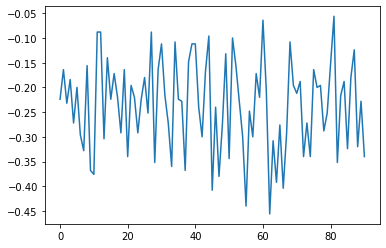

In [209]:
# Define variational circuit_variables
circuit_depth = 3
n_features = 2
n_labels = 1

intermediate_results = []

def objective_function(params):
    # construct circuit with given params
    qc = build_gan_stack(circuit_depth, n_features, n_labels, params)
    
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=qc, shots=500)
    counts = job.result().get_counts()
    
    result = 2 * counts['0'] / sum(counts.values()) - 1
    
    print("Intermediate:", -result)
    intermediate_results.append(-result)
    
    return -result
    
    
def generate_params(circuit_depth, n_features, n_labels):
    
    n_qubits = math.ceil(math.log2(n_features)) + n_labels

    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum

    n_qubits_per_layer = n_qubits + seriessum(n_qubits)
    n_rot_qubits_per_layer = n_qubits
    n_entangle_qubits_per_layer = seriessum(n_qubits)

    generated_params = np.random.rand(circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi
    
    return generated_params
    
init_params = generate_params(circuit_depth, n_features, n_labels)

print("Initial parameters:", init_params)
# objective_function(params)
    
optimizer = COBYLA(maxiter=100)

ret = optimizer.optimize(num_vars=len(init_params), objective_function=objective_function, initial_point=init_params)

print("Supposed optimal parameters:", ret)

plt.plot(intermediate_results)
plt.show()
